**Health Analytics Assignment 2**

Importing Required Libraries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import spacy
import scispacy
from scispacy.linking import EntityLinker
from scispacy.abbreviation import AbbreviationDetector
from bs4 import BeautifulSoup
import unidecode
from nltk.corpus import stopwords
import nltk
import pandas as pd
import spacy
from negspacy.negation import Negex
from negspacy.termsets import termset
from spellchecker import SpellChecker


Importing the Excel File

In [40]:
df=pd.read_csv("mtsamples_curated.csv")
df.head()

,report_id,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,1,4932,Coronary bypass graft x2 utilizing left inter...,Cardiovascular / Pulmonary,CABG - 1,"PREOPERATIVE DIAGNOSIS: , Coronary occlusive d...","cardiovascular / pulmonary, coronary occlusive..."
1,2,4638,Left muscle sparing mini thoracotomy with lef...,Cardiovascular / Pulmonary,Thoracotomy & Lobectomy,"PREOPERATIVE DIAGNOSES:,1. Non-small-cell car...","cardiovascular / pulmonary, upper lobe, interc..."
2,3,4620,Urgent cardiac catheterization with coronary ...,Cardiovascular / Pulmonary,Urgent Cardiac Cath,"PROCEDURE: , Urgent cardiac catheterization wi...","cardiovascular / pulmonary, cardiac catheteriz..."
3,4,4919,"Left heart catheterization, LV cineangiograph...",Cardiovascular / Pulmonary,Cardiac Catheterization,"EXAMINATION: , Cardiac catheterization.,PROCED...","cardiovascular / pulmonary, heart catheterizat..."
4,5,4662,Stress test - Adenosine Myoview. Ischemic ca...,Cardiovascular / Pulmonary,Stress Test Adenosine Myoview,"INDICATIONS:, Ischemic cardiomyopathy, status...","cardiovascular / pulmonary, stress test, adeno..."


Retain critical negation words during preprocessing (so the NegEx model can correctly detect negated medical entities)

In [41]:
STOP_WORDS = set(stopwords.words("english")) 
NEGATION_KEEP = {"no","not","never","without","neither","nor","denies","denied","denying","declines","negative"}
STOP_WORDS = STOP_WORDS - NEGATION_KEEP

**Handling Incorrect Spelling**

This function uses the PySpellChecker library to correct misspelled words in the text. It skips short words, uppercase tokens, and non-alphabetic terms, then replaces only likely typos with their correct forms. Most medical terms are written in uppercase letters hence we decided to skip uppercase tokens

In [42]:
speller = SpellChecker(distance=1)

def spell_fix_text(text):
    out = []
    for tok in text.split():
        if not tok.isalpha() or tok.isupper() or len(tok) < 5:
            out.append(tok)
            continue
        lower = tok.lower()
        if not speller.unknown([lower]):
            out.append(tok)
            continue
        corr = speller.correction(lower)
        out.append(corr if corr else tok)
    return " ".join(out)


**Handling unicode characters**

This converts all Unicode characters in the text to their closest ASCII equivalents

In [43]:
def normalize_unicode(text):
    text = str(text)
    return unidecode.unidecode(text)

**Handling HTML Tags**

This function uses BeautifulSoup to remove any HTML tags from the text so that only the plain, readable text content remains, cleaning up reports that may contain HTML formatting or markup.

In [44]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

**Removing punctuation and whitespaces**

Using regex patterns we are removing punctuations and whitespaces from our text to reduce noise

In [110]:
def punct_and_space(t: str) -> str:
    # 1) Turn hyphens BETWEEN word chars into spaces: "pre-op" -> "pre op"
    t = re.sub(r"(?<=\w)-(?=\w)", " ", t)
    # 2) Replace remaining punctuation with SPACE (never with empty string)
    t = re.sub(r"[^\w\s+]", " ", t)
    # 3) Collapse whitespace
    return re.sub(r"\s+", " ", t).strip()

**Regex Patterns for text anonymization**

In [111]:
EMAIL_RE = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")
PHONE_RE = re.compile(r"\b(?:\+?\d[\d\-\s]{7,}\d)\b")
DATE_RES = [re.compile(p, re.IGNORECASE) for p in [
    r"\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b",
    r"\b\d{4}[/-]\d{1,2}[/-]\d{1,2}\b",
    r"\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Sept|Oct|Nov|Dec)[a-z]*\.?\s*\d{1,2},?\s*\d{2,4}\b"
]]
NUM_RE   = re.compile(r"\b\d+(?:\.\d+)?\b")

**Lemmatization**

Lemmatization reduces each word in the clinical note to its **base or dictionary form**
This helps standardize medical text and improve downstream entity recognition.

In [112]:
nlp = spacy.load('en_core_sci_sm')
def lemmatization(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])


**Stop Word Removal**

This step removes common non-informative words
to reduce noise and retain only meaningful medical terms.  
However, we **intentionally keep clinical negation words** (e.g., “no”, “denies”)  
to ensure accurate negation detection later using NegEx.

In [113]:
def remove_stopwords(text):
    return " ".join([w for w in text.split() if w.lower() not in STOP_WORDS])

**Anonymizing dates**

In [114]:
def anonymize_dates(t):
    for rx in DATE_RES:
        t = rx.sub(" <DATE> ", t)
    return t

**Anonymizing numbers**

In [115]:
def normalize_numbers(t):
    return NUM_RE.sub("<NUM>", t)

**Creating a Preprocessing Pipeline**

In [133]:
def preprocess_one(t):
    t = str(t)
    t = normalize_unicode(t)
    t = EMAIL_RE.sub(" <EMAIL> ", t)
    t = PHONE_RE.sub(" <PHONE> ", t)
    t = remove_stopwords(t)
    t = lemmatization(t)
    t = punct_and_space(t)
    t = spell_fix_text(t)
    return t.lower()

**Applying Preprocessing on the CSV FILE**

We import the **mtsamples_curated.csv** dataset and apply our custom preprocessing 
pipeline to the **transcription** column to clean and standardize the text.  
This ensures the clinical notes are properly prepared for accurate **UMLS-based entity extraction**.

In [134]:
df = pd.read_csv("mtsamples_curated.csv")

df['transcription'] = df['transcription'].apply(preprocess_one)

df.head()


,report_id,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,1,4932,Coronary bypass graft x2 utilizing left inter...,Cardiovascular / Pulmonary,CABG - 1,preoperative diagnosis coronary occlusive dise...,"cardiovascular / pulmonary, coronary occlusive..."
1,2,4638,Left muscle sparing mini thoracotomy with lef...,Cardiovascular / Pulmonary,Thoracotomy & Lobectomy,preoperative diagnoses 1 non small cell carcin...,"cardiovascular / pulmonary, upper lobe, interc..."
2,3,4620,Urgent cardiac catheterization with coronary ...,Cardiovascular / Pulmonary,Urgent Cardiac Cath,procedure urgent cardiac catheterization coron...,"cardiovascular / pulmonary, cardiac catheteriz..."
3,4,4919,"Left heart catheterization, LV cineangiograph...",Cardiovascular / Pulmonary,Cardiac Catheterization,examination cardiac catheterization procedure ...,"cardiovascular / pulmonary, heart catheterizat..."
4,5,4662,Stress test - Adenosine Myoview. Ischemic ca...,Cardiovascular / Pulmonary,Stress Test Adenosine Myoview,indication ischemic cardiomyopathy status post...,"cardiovascular / pulmonary, stress test, adeno..."


**UMLS Entity Linking Setup**

In this step, we load a biomedical spaCy model (**en_ner_bc5cdr_md**) and attach the 
**scispaCy UMLS linker**, which maps medical entities from the clinical text to 
standardized UMLS (CUIs).  
We also define a dictionary to translate UMLS TUI codes into readable medical categories 

In [135]:
import spacy
from negspacy.negation import Negex
from negspacy.termsets import termset

import pandas as pd
TUI_LABELS = {
    "T047": "Disease or Syndrome",
    "T033": "Finding",
    "T184": "Sign or Symptom",
    "T121": "Pharmacologic Substance",
    "T109": "Organic Chemical",
    "T061": "Therapeutic or Preventive Procedure",
    "T046": "Pathologic Function",
}

def build_pipeline(model="en_ner_bc5cdr_md", threshold=0.75, max_candidates=5, resolve_abbr=True):
    nlp = spacy.load(model)
    nlp.add_pipe(
        "scispacy_linker",
        config={
            "resolve_abbreviations": resolve_abbr,
            "linker_name": "umls",               
            "max_entities_per_mention": max_candidates,
            "threshold": threshold,              
        }  )
    return nlp

**UMLS Mapping Function**

This function takes each clinical note and uses SciSpaCy to detect medical entities.
It then links those entities to standardized **UMLS medical concepts** (CUIs) and keeps only
the ones that belong to clinically meaningful categories.
For every valid entity, it returns the original text span, the matched UMLS concept, its
medical category, and the matching confidence score. The min_score value controls how strict
the matching is.

In [136]:
def map_to_umls(texts, nlp, min_score=0.75):
    linker = nlp.get_pipe("scispacy_linker")
    rows = []

    for i, text in enumerate(texts):
        doc = nlp(text)
        for ent in doc.ents:
            for cui, score in ent._.kb_ents[:3]:
                if score < min_score:
                    continue

                kb_ent = linker.kb.cui_to_entity.get(cui)
                if not kb_ent:
                    continue

                tui_list = list(kb_ent.types)
                
                if set(tui_list) & set(TUI_LABELS.keys()):
                    rows.append({
                        "row_id": i,
                        "span": ent.text,
                        "cui": cui,
                        "canonical_name": kb_ent.canonical_name,
                        "aliases_sample": "; ".join(list(kb_ent.aliases)[:3]),
                        "semantic_types": ";".join(tui_list),
                        "semantic_labels": ";".join([TUI_LABELS.get(t, t) for t in tui_list]),
                        "score": float(score),
                    })
    return pd.DataFrame(rows)


**UMLS Entity Extraction**

We now pass the preprocessed clinical notes through our UMLS-enabled SciSpaCy pipeline.
This extracts medical entities, links them to standardized UMLS concepts,
and returns the most confident matches for each note based on a similarity score threshold

In [137]:
nlp = build_pipeline(model="en_ner_bc5cdr_md", threshold=0.75)

sample_texts = df['transcription'].tolist()
umls_df = map_to_umls(sample_texts, nlp, min_score=0.75)
umls_df.sort_values(["row_id", "score"], ascending=[True, False]).head(20)

,row_id,span,cui,canonical_name,aliases_sample,semantic_types,semantic_labels,score
3,0,potassium,C0032821,potassium,"Potassium; Potassium, elemental; potassium",T121;T123;T196,Pharmacologic Substance;T123;T196,1.000000
4,0,potassium,C0304475,Potassium supplement,"Potassium; Potassium supplement, NOS; Medicina...",T121;T197,Pharmacologic Substance;T197,1.000000
5,0,papaverine,C0030350,papaverine,PAPAVERINE; Product containing papaverine (med...,T109;T121,Organic Chemical;Pharmacologic Substance,1.000000
7,0,potassium,C0032821,potassium,"Potassium; Potassium, elemental; potassium",T121;T123;T196,Pharmacologic Substance;T123;T196,1.000000
8,0,potassium,C0304475,Potassium supplement,"Potassium; Potassium supplement, NOS; Medicina...",T121;T197,Pharmacologic Substance;T197,1.000000
9,0,potassium,C0032821,potassium,"Potassium; Potassium, elemental; potassium",T121;T123;T196,Pharmacologic Substance;T123;T196,1.000000
10,0,potassium,C0304475,Potassium supplement,"Potassium; Potassium supplement, NOS; Medicina...",T121;T197,Pharmacologic Substance;T197,1.000000
15,0,protamine,C0033603,protamines,Protamine; Protamine (substance); Protamine-co...,T116;T121;T123,T116;Pharmacologic Substance;T123,1.000000
0,0,coronary occlusive disease,C4020725,Nonocclusive coronary artery atherosclerosis,Non-occlusive coronary artery stenosis; Non-oc...,T047,Disease or Syndrome,0.835957
11,0,partial occlusion,C0154839,Partial retinal artery occlusion,Partial Retinal Arterial Occlusion; Partial re...,T047,Disease or Syndrome,0.811023


**Summary of Extracted Medical Concepts**

In [138]:
print("\n--- Top semantic types ---")
print(umls_df['semantic_labels'].value_counts().head(10))

print("\n--- Most frequent concepts ---")
print(umls_df['canonical_name'].value_counts().head(10))


--- Top semantic types ---
semantic_labels
Disease or Syndrome                              9033
Sign or Symptom                                  4364
Finding                                          3230
Pathologic Function                              3121
Organic Chemical;Pharmacologic Substance         2647
Therapeutic or Preventive Procedure               621
Pharmacologic Substance                           347
Organic Chemical;Pharmacologic Substance;T123     241
Pharmacologic Substance;T123;T196                 215
Organic Chemical;T195                             193
Name: count, dtype: int64

--- Most frequent concepts ---
canonical_name
Pain                      669
Hemorrhage                240
Edema                     232
Hypersensitivity          227
Stenosis                  219
Fracture care             204
Diastolic hypertension    199
Hypertensive disease      198
Dyspnea                   186
Tumor Mass                173
Name: count, dtype: int64


**Negation Detection using NEGEX**

This step adds the NegEx component to detect whether each medical entity in the text  
is **present or negated** — for example, “no diabetes” or “denies chest pain” would be marked as negated.The **map_negation()** function returns a table showing each entity with its negation status.

In [139]:
nlp = spacy.load("en_ner_bc5cdr_md")

# Load clinical negation rules
ts = termset("en_clinical")

# Add Negex with rules  
nlp.add_pipe("negex", config={"neg_termset": ts.get_patterns()}, last=True)

def map_negation(texts, nlp, batch_size=16):
    rows = []
    for i, doc in enumerate(nlp.pipe(texts, batch_size=batch_size)):
        for ent in doc.ents:
            rows.append({
                "row_id": i,
                "span": ent.text,
                "label": ent.label_,
                "negated": bool(getattr(ent._, "negex", False)),
            })
    return pd.DataFrame(rows)


**Identifying Negated Medical Entities (NegEx)**

We run a negation detector (NegEx) to check whether each medical term in the notes is being confirmed or denied for example, sentences like “no fever” or “denies chest pain” should be marked as negated.
This step helps us avoid counting conditions that the patient does not actually have.

In [162]:
neg_df = map_negation(df["transcription"].tolist(), nlp)
neg_df[neg_df["negated"]].sample(15, random_state=0)

,row_id,span,label,negated
15295,783,confusion,DISEASE,True
10276,479,neuropathy,DISEASE,True
9807,452,vessel distal aneurysm,DISEASE,True
10099,470,heparin,CHEMICAL,True
7352,348,adenopathy,DISEASE,True
9000,411,pain,DISEASE,True
15333,786,gentamicin tobramycin,CHEMICAL,True
7177,340,cholesterol,CHEMICAL,True
2866,177,pain,DISEASE,True
7644,360,potassium,CHEMICAL,True


**Visualization for Top Entities and Their Negation Status**

This chart shows the most frequent medical entities mentioned in the clinical notes,
split into affirmed (patient has it) vs negated (patient explicitly does not have it).
This helps us understand which conditions are commonly discussed and how often they are being ruled out.

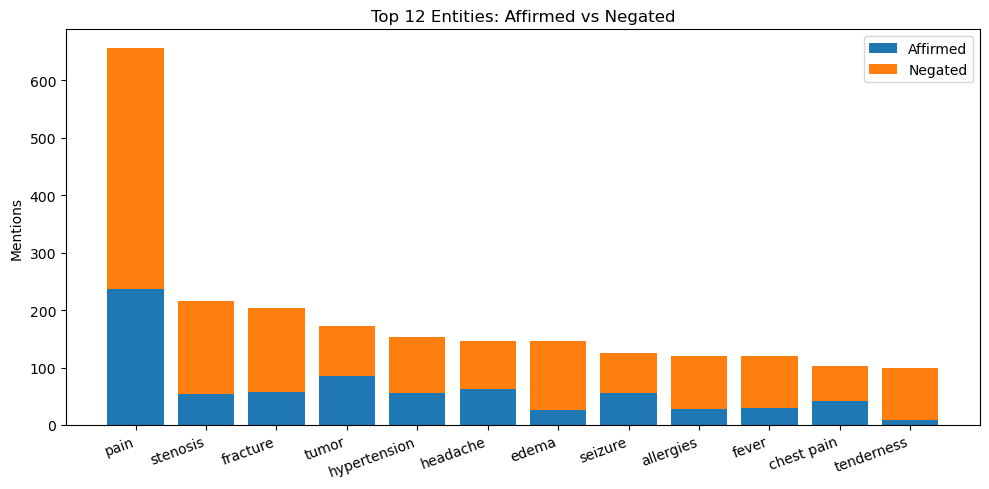

In [169]:
plt.figure(figsize=(10,5))
plt.bar(top.index, top.get(False, 0), label="Affirmed")
plt.bar(top.index, top.get(True, 0), bottom=top.get(False, 0), label="Negated")
plt.xticks(rotation=20, ha="right"); plt.ylabel("Mentions")
plt.title(f"Top {N} Entities: Affirmed vs Negated")
plt.legend(); plt.tight_layout(); plt.show()


**Comparison of keyword search with entity extraction**

In this step, we evaluate how many clinical notes mention our target medical terms using two different methods:

Keyword Search:
We directly search for exact text matches inside the raw transcription column using simple string matching.

Entity Search (NER Model):
We use the pre-trained clinical NER model to extract medical entities from each note.
Then, instead of checking raw text, we search inside the detected medical entities, which is more reliable and medically aware.

We store both results so we can later compare how many notes each method successfully detects.

In [170]:
keywords = ["diabetes", "hypertension", "cancer", "metformin"]

kw_counts = {} 

print("----- KEYWORD SEARCH (simple string matching) -----")
for x in keywords:
    count = df["transcription"].str.contains(x, case=False, na=False).sum()
    kw_counts[x] = count
    print(f"'{x}' found in {count} notes (keyword search)")

print("\n----- ENTITY SEARCH (NER MODEL) -----")

all_entities = []
for text in df["transcription"]:
    doc = nlp(text)
    entities_in_note = [ent.text.lower() for ent in doc.ents]
    all_entities.append(entities_in_note)

df["entities"] = all_entities

ner_counts = {} 
for x in keywords:
    count = df["entities"].apply(lambda ents: x.lower() in ents).sum()
    ner_counts[x] = count
    print(f"NER hits for '{x}': {count}")


----- KEYWORD SEARCH (simple string matching) -----
'diabetes' found in 115 notes (keyword search)
'hypertension' found in 146 notes (keyword search)
'cancer' found in 79 notes (keyword search)
'metformin' found in 16 notes (keyword search)

----- ENTITY SEARCH (NER MODEL) -----
NER hits for 'diabetes': 40
NER hits for 'hypertension': 102
NER hits for 'cancer': 22
NER hits for 'metformin': 7


Here we are making a table which will compare the results of the Entity search and keyword search 

In [ ]:
comparison_df = pd.DataFrame({
    "keyword": keywords,
    "notes_with_keyword": [df["transcription"].str.contains(x, case=False, na=False).sum() for x in keywords],
    "notes_with_entity_match": [df["entities"].apply(lambda ents: x.lower() in ents).sum() for x in keywords]
})

print("\n--- KEYWORD vs ENTITY SEARCH COMPARISON ---")
display(comparison_df)



--- KEYWORD vs ENTITY SEARCH COMPARISON ---


,keyword,notes_with_keyword,notes_with_entity_match
0,diabetes,115,40
1,hypertension,146,102
2,cancer,79,22
3,metformin,16,7


**Most Frequently Detected UMLS Entities**

We count how many times each canonical UMLS medical concept appears across all clinical notes. This helps us identify the most common medical conditions, findings, or substances mentioned in the dataset.

In [ ]:
ent_counts = (
    umls_df["canonical_name"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "canonical_name", "canonical_name": "count"}))

print(ent_counts.head())
print(ent_counts.columns)


              count  count
0              Pain    669
1        Hemorrhage    240
2             Edema    232
3  Hypersensitivity    227
4          Stenosis    219
Index(['count', 'count'], dtype='object')


This bar chart shows the most commonly mentioned medical concepts detected using the UMLS based entity linking pipeline.
Each bar represents how many times a specific medical concept appears across all clinical notes. This helps identify which health conditions are discussed most frequently in the dataset.

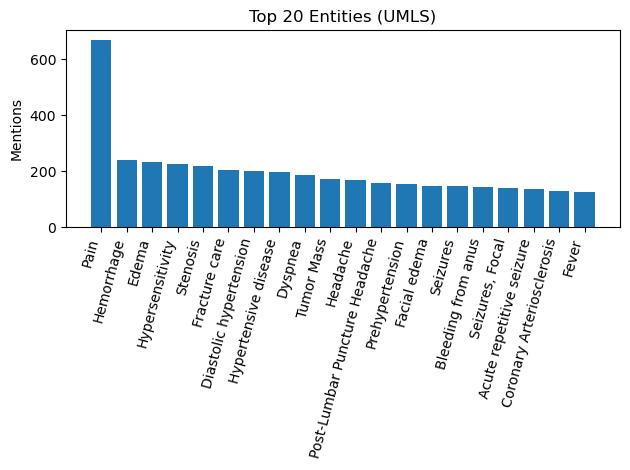

In [176]:
TOP_N = 20
ent_counts.columns = ["entity_name", "entity_mentions"]

top_entities = ent_counts.head(TOP_N)

plt.figure()
plt.bar(top_entities["entity_name"], top_entities["entity_mentions"])
plt.title(f"Top {TOP_N} Entities (UMLS)")
plt.xticks(rotation=75, ha="right")
plt.ylabel("Mentions")
plt.tight_layout()
plt.show()


**Visualizing top medical semantics**

This chart shows the most common categories of medical entities detected in the clinical notes, based on UMLS semantic labels such as whether the entity is a disease, symptom, finding, medication, or procedure.

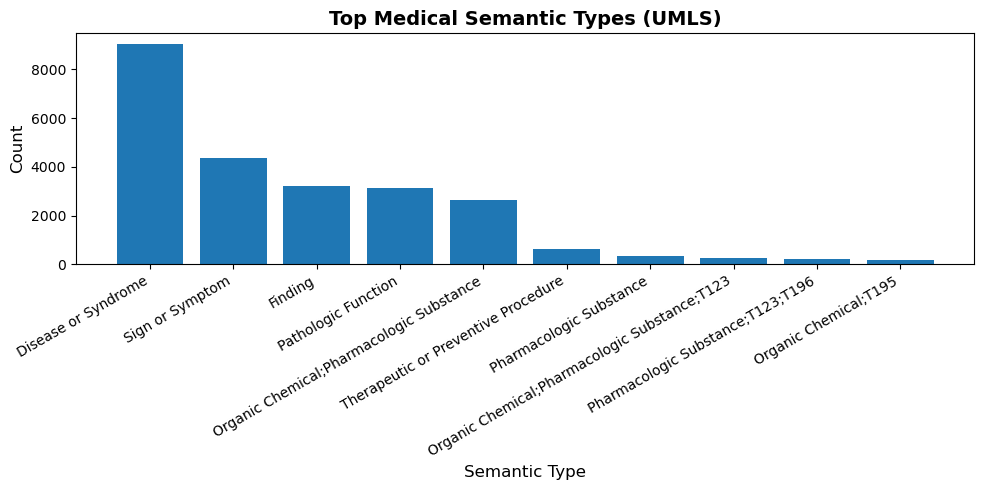

Entity Type Counts:
 semantic_labels
Disease or Syndrome                              9033
Sign or Symptom                                  4364
Finding                                          3230
Pathologic Function                              3121
Organic Chemical;Pharmacologic Substance         2647
Therapeutic or Preventive Procedure               621
Pharmacologic Substance                           347
Organic Chemical;Pharmacologic Substance;T123     241
Pharmacologic Substance;T123;T196                 215
Organic Chemical;T195                             193
Name: count, dtype: int64


In [ ]:
entity_type_counts = umls_df["semantic_labels"].value_counts().head(10)

plt.figure(figsize=(10, 5))
plt.bar(entity_type_counts.index, entity_type_counts.values)
plt.title("Top Medical Semantic Types (UMLS)", fontsize=14, fontweight="bold")
plt.xlabel("Semantic Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

print("Entity Type Counts:\n", entity_type_counts)


**Report about my Finding**

In this assignment we took a medical notes dataset and focused on the transcription column for processing. We first performed preprocessing by removing HTML tags, Unicode characters, punctuation, and other noise. We also corrected spelling mistakes to prevent inaccurate entity detection during analysis. Once the preprocessing was complete, we proceeded to the UMLS mapping step.

Next, I used the en_ner_bc5cdr_md model, which is a medical NER model trained specifically on biomedical data. This allowed us to automatically detect medical entities such as diseases, symptoms, drugs, and procedures from each note. I also applied UMLS mapping, which converts each detected entity into its official standardized medical term using a unique clinical ID (CUI). This makes the data more organized and consistent rather than just raw word

After mapping, we extended the pipeline by adding NegEx, a clinical negation detection algorithm. This allowed us to identify whether a medical entity is affirmed or negated in the context. This is a critical step because it prevents us from falsely counting conditions that are explicitly ruled out.

Next, I compared keyword search and NER. Using a list of target keywords diabetes, hypertension, cancer, and metformin.We searched for direct keyword matches in the transcription column. Then, I used the NER model to identify mentions of these same medical terms as entities. The results showed that simple keyword search often found more notes than NER, but the NER-based method provided more precise, medically contextual results.

‘diabetes’ was found in 115 notes using keyword search and 40 using NER.

‘hypertension’ appeared in 146 notes with keyword search and 102 with NER.

‘cancer’ occurred in 79 keyword matches and 22 NER matches.

‘metformin’ was found in 16 notes via keyword search and 7 using NER.


After entity extraction, I analyzed the most frequent clinical concepts. The top 20 entities detected from the dataset and the top 5  were: Pain (669 mentions), Hemorrhage (240), Edema (232), Hypersensitivity (227), and Stenosis (219). This reflects common topics mentioned across the clinical notes.

When examining semantic label distributions, the most dominant type was Disease or Syndrome (9033 mentions), followed by Sign or Symptom (4364), Finding (3230), Pathologic Function (3121), and Organic Chemical/Pharmacologic Substance (2647). These labels provide a high level understanding of the types of medical entities most commonly referenced in the dataset.

 Finally, we visualized the most frequent medical entities and semantic types to better understand what medical concepts appear most commonly in the dataset.Theough all of this it was prooven that NER combined with UMLS and NegEx is much more powerful and reliable than basic keyword search. It allows us to extract clinically meaningful insights rather than just matching words.